[View in Colaboratory](https://colab.research.google.com/github/mxchauhan/Capstone/blob/master/3_2_5+Random+Forest+Guided+Example.ipynb)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club to predict the state of a loan given some information about it. You can find the dataset [here](https://www.lendingclub.com/info/download-data.action). We'll use 2015 data. ([Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0))

In [35]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


## The Blind Approach

Now, as we've seen before, creating a model is the easy part. Let's try just using everything we've got and throwing it without much thought into a Random Forest. SKLearn requires the independent variables to be be numeric, and all we want is dummy variables so let's use `get_dummies` from Pandas to generate a dummy variable for every categorical colummn and see what happens off of this kind of naive approach.

In [0]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

#rfc = ensemble.RandomForestClassifier()
#X = y2015.drop('loan_status', 1)
#Y = y2015['loan_status']
#X = pd.get_dummies(X)
#X
#cross_val_score(rfc, X, Y, cv=5)

Did your kernel die? My kernel died.

Guess it isn't always going to be that easy...

Can you think of what went wrong?

(You're going to have to reset your kernel and reload the column, BUT DON'T RUN THE MODEL AGAIN OR YOU'LL CRASH THE KERNEL AGAIN!)

## Data Cleaning

Well, `get_dummies` can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier. Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [38]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [0]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [40]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

In [42]:
y2015

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,60 months,14.85,379.39,C,10+ years,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,36 months,7.49,298.58,A,8 years,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,36 months,7.49,777.55,A,10+ years,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,36 months,6.49,858.05,A,10+ years,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,36 months,19.89,320.99,E,8 years,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0
5,68506798.0,73396623.0,23000.0,23000.0,23000.0,60 months,8.49,471.77,B,5 years,...,0.0,2.0,87.9,14.3,0.0,0.0,93962.0,63886.0,39500.0,46662.0
6,68566886.0,73456723.0,29900.0,29900.0,29900.0,60 months,12.88,678.49,C,10+ years,...,0.0,4.0,100.0,25.0,0.0,0.0,271700.0,42497.0,34000.0,15574.0
7,68577849.0,73467703.0,18000.0,18000.0,18000.0,60 months,11.99,400.31,C,10+ years,...,0.0,4.0,100.0,0.0,0.0,0.0,309710.0,36127.0,69800.0,26210.0
8,66310712.0,71035433.0,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,10+ years,...,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0
9,68476807.0,73366655.0,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,3 years,...,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0


In [43]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

term
2
grade
7
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
purpose
14
title
27
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


Now this should be better. Let's try again.

In [44]:
pd.get_dummies(y2015)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_INDIVIDUAL,application_type_JOINT,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,...,0,0,0,0,0,1,0,0,0,0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,...,0,0,0,0,0,1,0,0,0,0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,...,0,0,0,0,0,1,0,0,0,0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,...,0,0,0,0,0,1,0,0,0,0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,...,0,0,0,0,0,1,0,0,0,0
5,68506798.0,73396623.0,23000.0,23000.0,23000.0,8.49,471.77,64000.0,18.28,0.0,...,0,0,0,0,0,1,0,0,0,0
6,68566886.0,73456723.0,29900.0,29900.0,29900.0,12.88,678.49,65000.0,21.77,0.0,...,0,0,0,0,0,1,0,0,0,0
7,68577849.0,73467703.0,18000.0,18000.0,18000.0,11.99,400.31,112000.0,8.68,0.0,...,0,0,0,0,0,1,0,0,0,0
8,66310712.0,71035433.0,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,...,0,0,0,0,0,1,0,0,0,0
9,68476807.0,73366655.0,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,...,0,0,0,0,0,1,0,0,0,0


It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [45]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.97967277, 0.98036143, 0.98157251, 0.98185747, 0.97276181,
       0.97876989, 0.95832245, 0.98059797, 0.98026456, 0.98047784])

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [46]:
# Your code here.

X = X.loc[:,'loan_amnt':'total_il_high_credit_limit']
X.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,0.0,11.0,...,0.0,0.0,2.0,78.9,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,0.0,7.0,...,0.0,0.0,2.0,100.0,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,1.0,9.0,...,0.0,0.0,0.0,100.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,0.0,16.0,...,0.0,0.0,0.0,91.7,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,4.0,18.0,...,0.0,0.0,12.0,100.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [47]:
X = X.select_dtypes(include=['float64'])
X.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,0.0,11.0,...,0.0,0.0,2.0,78.9,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,0.0,7.0,...,0.0,0.0,2.0,100.0,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,1.0,9.0,...,0.0,0.0,0.0,100.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,0.0,16.0,...,0.0,0.0,0.0,91.7,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,4.0,18.0,...,0.0,0.0,12.0,100.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [48]:
for col in X.columns:
    print(col)

loan_amnt
funded_amnt
funded_amnt_inv
int_rate
installment
annual_inc
dti
delinq_2yrs
inq_last_6mths
open_acc
pub_rec
revol_bal
total_acc
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_amnt
collections_12_mths_ex_med
policy_code
acc_now_delinq
tot_coll_amt
tot_cur_bal
total_rev_hi_lim
acc_open_past_24mths
avg_cur_bal
chargeoff_within_12_mths
delinq_amnt
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
num_accts_ever_120_pd
num_actv_bc_tl
num_actv_rev_tl
num_bc_sats
num_bc_tl
num_il_tl
num_op_rev_tl
num_rev_tl_bal_gt_0
num_sats
num_tl_30dpd
num_tl_90g_dpd_24m
num_tl_op_past_12m
pct_tl_nvr_dlq
pub_rec_bankruptcies
tax_liens
tot_hi_cred_lim
total_bal_ex_mort
total_bc_limit
total_il_high_credit_limit


                            loan_amnt  funded_amnt  funded_amnt_inv  int_rate  \
loan_amnt                    1.000000     1.000000         0.999994  0.140572   
funded_amnt                  1.000000     1.000000         0.999994  0.140572   
funded_amnt_inv              0.999994     0.999994         1.000000  0.140209   
int_rate                     0.140572     0.140572         0.140209  1.000000   
installment                  0.941205     0.941205         0.941187  0.124426   
annual_inc                   0.305734     0.305734         0.305803 -0.090399   
dti                          0.006103     0.006103         0.006044  0.077932   
delinq_2yrs                 -0.010424    -0.010424        -0.010448  0.043710   
inq_last_6mths              -0.039040    -0.039040        -0.039103  0.231139   
open_acc                     0.188214     0.188214         0.188212 -0.012985   
pub_rec                     -0.088899    -0.088899        -0.088885  0.058231   
revol_bal                   

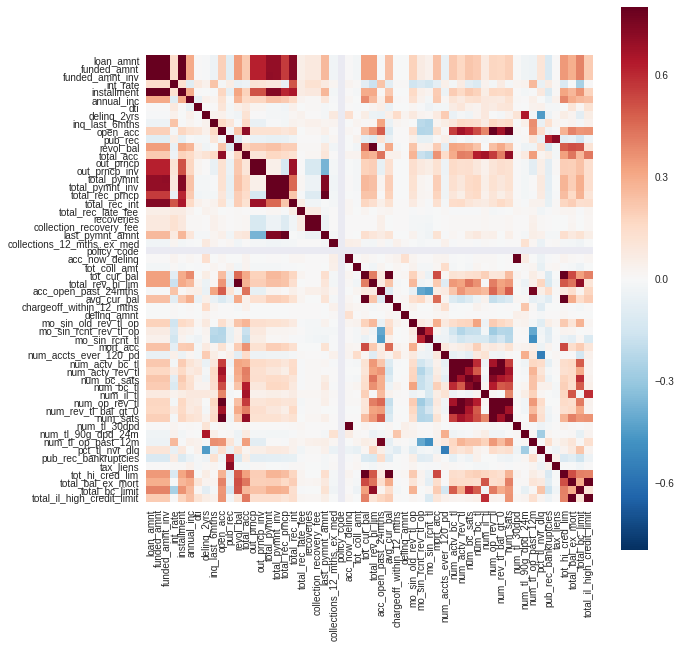

In [49]:
import seaborn as sns
corrmat = X.corr()
print(corrmat)

plt.figure(figsize=(10,10))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

### Remember to try PCA to reduce the dimensionality of the feature space

Recommendation: watch Andrew Ng's videos on this (week 8 of the ML Coursera course)

https://www.coursera.org/learn/machine-learning/lecture/0EJ6A/motivation-i-data-compression

This video should delve into it too 
https://www.coursera.org/learn/python-machine-learning/lecture/cgzXI/dimensionality-reduction-and-manifold-learning

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

for i in X.columns:
  X[col] = pd.to_numeric(X[col], errors='coerce')

# impute 0 to nans
X.fillna(value=0, inplace= True)
X_normalized = StandardScaler().fit(X).transform(X)

pca = PCA(n_components = 10).fit(X_normalized)

X_pca = pca.transform(X_normalized)

print(y2015.shape, X_pca.shape)

(421095, 103) (421095, 10)


In [53]:
X_pca_df = pd.DataFrame(data = X_pca
             , columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])

finalDf = pd.concat([X_pca_df, y2015[['loan_status']]], axis = 1)
finalDf

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,loan_status
0,3.629148,1.436018,-0.397794,3.429704,3.183030,1.583616,1.281309,4.204451,-0.563100,1.540205,Current
1,-3.346677,-0.648388,0.163879,0.894426,0.599912,-1.306987,-0.406767,-0.656556,0.221352,0.118541,Current
2,2.424156,-4.407939,0.721905,-3.785485,2.779972,-0.496940,-0.257803,-0.226446,-0.011868,0.176068,Fully Paid
3,4.248284,-0.968816,-1.058777,3.099248,1.858276,1.067126,0.077441,-0.027217,-0.749718,0.665492,Current
4,-0.124154,5.535738,-1.868699,-4.045714,-2.371737,-1.739732,0.058503,2.309375,1.695533,-1.616251,Fully Paid
5,2.284186,1.302557,-1.238445,2.374913,-0.398879,-0.091216,-0.790046,-1.226315,-0.581450,0.695770,Current
6,3.023497,-1.231492,-1.126615,2.302830,-1.754675,-1.040846,-0.331971,0.423082,0.688850,-0.912860,Current
7,3.284502,0.854015,-0.149444,-2.857706,3.247412,0.144336,0.074435,0.499703,0.441551,-0.684753,Fully Paid
8,4.007365,-2.941639,-2.074729,3.431001,-1.214461,-0.673558,0.017702,0.689011,0.827486,-1.077472,Current
9,1.203434,1.033330,2.727235,-2.565084,-0.483685,-0.767567,0.262532,0.798711,1.099941,-1.785124,Fully Paid


In [56]:
rfc = ensemble.RandomForestClassifier()
X_pca_df = pd.get_dummies(X_pca_df)
#X_pca_df = X_pca.dropna(axis=1)

cross_val_score(rfc, X_pca_df, finalDf.loan_status, cv=10)

array([0.92467526, 0.92864097, 0.92982831, 0.93101565, 0.93068155,
       0.93103776, 0.92923128, 0.92737895, 0.92568932, 0.91079656])